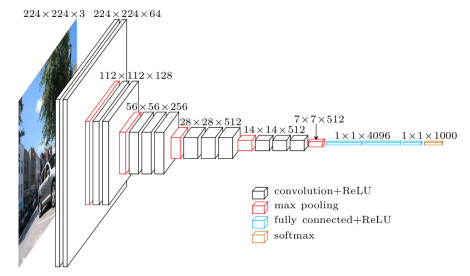

In [3]:
#import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import seaborn as sns
import numpy as np
from torch.utils.data import random_split
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
BATCH_SIZE=64
num_epochs=5
lr=1e-4
class_size=10

In [6]:

tranform_train = transforms.Compose([transforms.Resize((224,224)), transforms.RandomHorizontalFlip(p=0.7), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
tranform_test = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

#prep the train, validation and test dataset
torch.manual_seed(2021)
train = torchvision.datasets.CIFAR10("data/", train=True, download=True, transform=tranform_train) 
val_size = 10000 
train_size = len(train) - val_size
train, val = random_split(train, [train_size, val_size]) 
test = torchvision.datasets.CIFAR10("data/", train=False, download=True, transform=tranform_test) 

#  train, val and test datasets to the dataloader
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val, batch_size=BATCH_SIZE, shuffle=False)

100.0%


Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([64, 3, 224, 224])


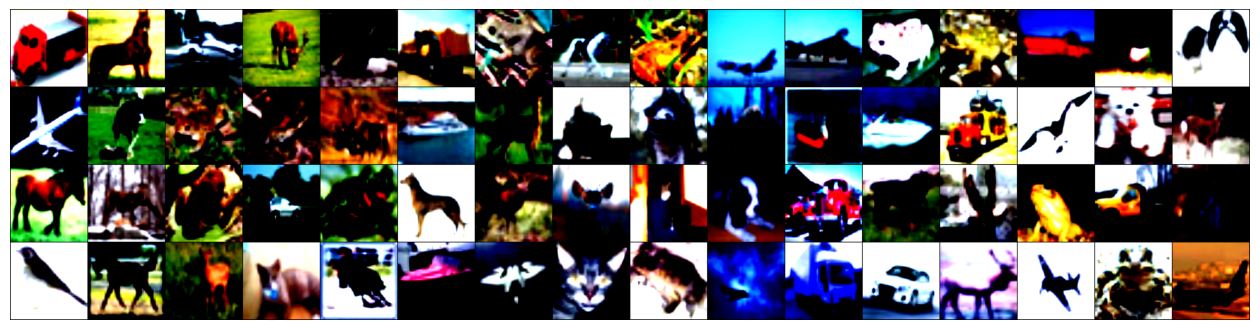

In [7]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [8]:
sample_image=iter(train_loader)
samples,labels=sample_image.next()
print(samples.shape) #64 batch size, 1 channel, width 224 , height 224
print(labels)

AttributeError: '_SingleProcessDataLoaderIter' object has no attribute 'next'

#### Unseen layers VGG employs ReLU in all of its secret layers (AlexNet came up with a big idea that sliced training time in half.). Local Response Normalization (LRN) is not used by VGG because It improves memory retention and training time while providing little improvement inaccuracy.

In [9]:
#how the maxpool works while we are preserving the shape in blocks by padding (1,1)
'''
    x = (width- kernel_size +2P) /S +1
    where P= padding
    S= strides
'''
import math
block1 =224
pool1 =math.ceil((block1-3)/2 +1)
print(pool1)


block2=pool1

pool2 =math.ceil((block2-3)/2 +1)
print(pool2)



block3=pool2
pool3 =math.ceil((block3-3)/2 +1)
print(pool3)


block4=pool3
pool4 =math.ceil((block4-3)/2 +1)
print(pool4)


block5=pool4
pool5 =math.ceil((block5-3)/2 +1)
print(pool5)


#After flatten 
flatten= pool5 * pool5 * 512
print(f'After flatten:: {flatten}')

112
56
28
14
7
After flatten:: 25088


In [10]:
class VGG16_NET(nn.Module):
    def __init__(self):
        super(VGG16_NET, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

        self.conv8 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv9 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv10 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.conv11 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv12 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv13 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc14 = nn.Linear(25088, 4096)
        self.fc15 = nn.Linear(4096, 4096)
        self.fc16 = nn.Linear(4096, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.maxpool(x)
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = self.maxpool(x)
        x = F.relu(self.conv8(x))
        x = F.relu(self.conv9(x))
        x = F.relu(self.conv10(x))
        x = self.maxpool(x)
        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        x = F.relu(self.conv13(x))
        x = self.maxpool(x)
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc14(x))
        x = F.dropout(x, 0.5) #dropout was included to combat overfitting
        x = F.relu(self.fc15(x))
        x = F.dropout(x, 0.5)
        x = self.fc16(x)
        return x

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
model = VGG16_NET() 
model = model.to(device=device) 
load_model = True
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= lr) 

In [12]:
for epoch in range(num_epochs): #I decided to train the model for 50 epochs
    loss_var = 0
    
    for idx, (images, labels) in enumerate(train_loader):
        images = images.to(device=device)
        labels = labels.to(device=device)
        ## Forward Pass
        optimizer.zero_grad()
        scores = model(images)
        loss = criterion(scores,labels)
        loss.backward()
        optimizer.step()
        loss_var += loss.item()
        if idx%64==0:
            print(f'Epoch [{epoch+1}/{num_epochs}] || Step [{idx+1}/{len(train_loader)}] || Loss:{loss_var/len(train_loader)}')
    print(f"Loss at epoch {epoch+1} || {loss_var/len(train_loader)}")

    with torch.no_grad():
        correct = 0
        samples = 0
        for idx, (images, labels) in enumerate(val_loader):
            images = images.to(device=device)
            labels = labels.to(device=device)
            outputs = model(images)
            _, preds = outputs.max(1)
            correct += (preds == labels).sum()
            samples += preds.size(0)
        print(f"accuracy {float(correct) / float(samples) * 100:.2f} percentage || Correct {correct} out of {samples} samples")

Epoch [1/5] || Step [1/625] || Loss:0.003681545639038086


KeyboardInterrupt: 

**MODEL CAN BE FURTHER TRAINED FOR BETTER ACCURACY ALSO Accuracy on each class can checked too**
## For more info check https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [11]:
#SAVE & LOAD
torch.save(model.state_dict(), "cifar10_vgg16_model.pt") #SAVES THE TRAINED MODEL
model = VGG16_NET()
model.load_state_dict(torch.load("cifar10_vgg16_model.pt")) #loads the trained model
model.eval()

VGG16_NET(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv10): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv11): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv12): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv13): Conv2d(512, 512, kernel_size=(3,

In [12]:
#TESTING LOOP SIMILAR TO VALIDATION(EVAL)
'''
test_loader = DataLoader(test, batch_size=8, shuffle=False)
correct = 0
samples = 0
for idx, (images, labels) in enumerate(test_dl):
    images = images.to(device='cpu')
    labels = labels.to(device='cpu')
    outputs = model(images)
    _, preds = outputs.max(1)
    correct += (preds == labels).sum()
    samples += preds.size(0)
print(f"accuracy {float(correct) / float(samples) * 100:.2f} percentage || Correct {correct} out of {samples} samples")
'''

'\ntest_loader = DataLoader(test, batch_size=8, shuffle=False)\ncorrect = 0\nsamples = 0\nfor idx, (images, labels) in enumerate(test_dl):\n    images = images.to(device=\'cpu\')\n    labels = labels.to(device=\'cpu\')\n    outputs = model(images)\n    _, preds = outputs.max(1)\n    correct += (preds == labels).sum()\n    samples += preds.size(0)\nprint(f"accuracy {float(correct) / float(samples) * 100:.2f} percentage || Correct {correct} out of {samples} samples")\n'